### Description: This script contains the codes for Random Forest modelling (section 5.3) and can be used to reproduce figures 5 & 6

### Import the necessary libraries

In [31]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.inspection import permutation_importance

### Read data

In [32]:
df = gpd.read_file('../data/processed/jkt_dist.shp')

### Predict only using population density and HDI

In [33]:
#fit random forest model
X = df[['Pop_den', "HDI", "urbanicity"]]  # Features
feature_names =  X.columns.tolist()
y = df['Cases']

# Stratify based on 'Province'
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, y, df.index, test_size=0.3, random_state=38, stratify = df["District"])

# Now you have train_index and test_index containing the original indices
# of the rows that went into training and testing sets respectively.

### Figure 6

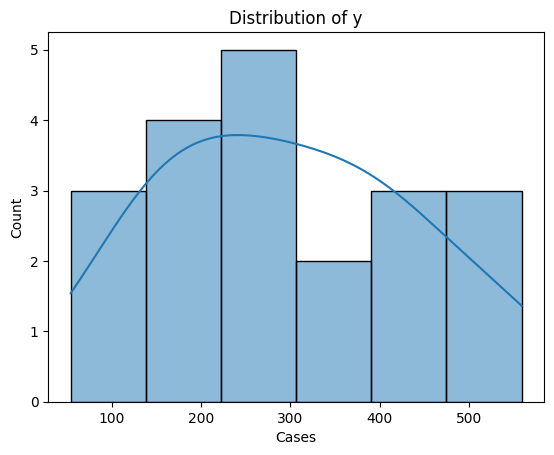

Skewness: 0.23139264883072874


In [34]:
#plot the distribution of y to determine whether i need to log transform it

# Plot the distribution of y
sns.histplot(y, kde=True)
plt.title("Distribution of y")
plt.show()

# Check if the distribution is highly skewed (optional)
skewness = y.skew()
print(f"Skewness: {skewness}")

# If skewed, apply log transformation and plot again
if skewness > 1:  # You can adjust this threshold based on your data
    y_log = np.log1p(y_train)  # log1p is log(1 + y), handles zeros gracefully
    sns.histplot(y_log, kde=True)
    plt.title("Log-transformed Distribution of y")
    plt.show()


### Stats in section 5.3 abt the Jarque-Bera test

In [ ]:
#test for normality

from scipy.stats import jarque_bera

# Assume `y` is your array of raw case counts
statistic, p_value = jarque_bera(y)

print(f"Jarque-Bera statistic: {statistic}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Fail to reject normality (data is approximately normal)")
else:
    print("Reject normality (data is not normal)")

Jarque-Bera statistic: 0.8435395352581075
p-value: 0.6558850279766042
Fail to reject normality (data is approximately normal)


### Figure 5

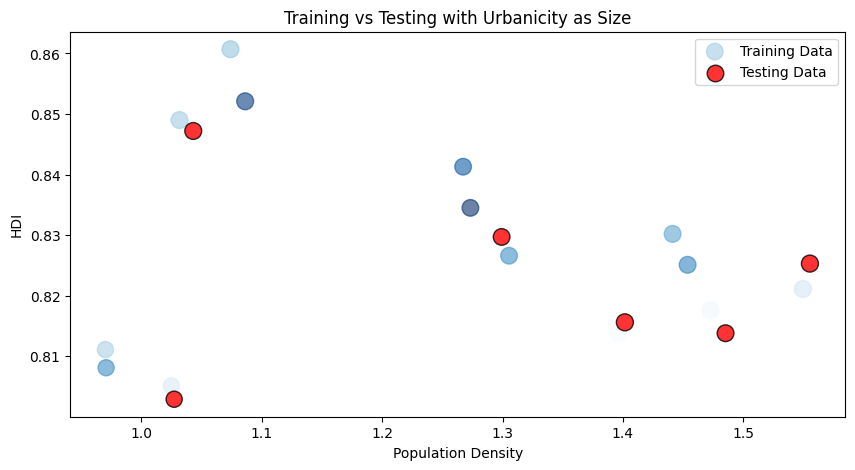

In [35]:
plt.figure(figsize=(10, 5))

# Training data
plt.scatter(X_train['Pop_den'], X_train['HDI'], 
            c=y_train, cmap='Blues', 
            s=50 + 100 * X_train['urbanicity'],  # marker size varies with urbanicity
            alpha=0.6, label='Training Data')

# Testing data
plt.scatter(X_test['Pop_den'], X_test['HDI'], 
            c='red', edgecolors='k', 
            s=50 + 100 * X_test['urbanicity'], 
            alpha=0.8, label='Testing Data')

plt.xlabel('Population Density')
plt.ylabel('HDI')
plt.title('Training vs Testing with Urbanicity as Size')
plt.legend()
plt.show()


In [36]:
# Define your param grid
param_grid = {'n_estimators': [100, 200, 300, 500, 1000]}

# Evaluation function
def evaluate_model(y_true, y_pred, label):
    return {
        'version': label,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

# Grid Search function
def run_grid_search(X, y, cv_folds=10):
    grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                        cv=cv_folds, n_jobs=-1, scoring='neg_root_mean_squared_error')
    grid.fit(X, y)
    return int(grid.best_params_['n_estimators'])

results = []

### 1. Original y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=38, stratify = df["District"])
n_original = run_grid_search(X_train, y_train)
rf = RandomForestRegressor(n_estimators=n_original, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
results.append(evaluate_model(y_test, y_pred, "original"))

In [37]:
print(results)

[{'version': 'original', 'MAE': 61.784833333333324, 'RMSE': np.float64(88.06237035476617), 'R2': 0.3286780118307625}]


In [47]:
print(n_original)

1000


C:\Users\jessi\AppData\Local\Temp\ipykernel_7300\213404950.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color="blue")


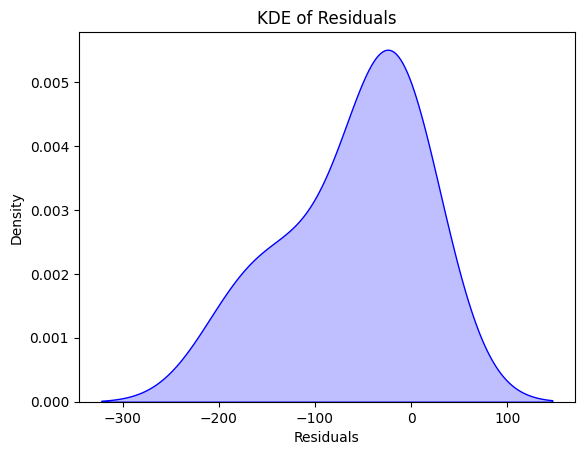

In [38]:
#plot the distribution of errors
# Calculate residuals (difference between observed and predicted values)
residuals = y_test - y_pred

# Plot KDE of residuals
sns.kdeplot(residuals, shade=True, color="blue")
plt.title('KDE of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

In [46]:
#test for normality

from scipy.stats import jarque_bera

# Assume `y` is your array of raw case counts
statistic, p_value = jarque_bera(residuals)

print(f"Jarque-Bera statistic: {statistic}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Fail to reject normality (data is approximately normal)")
else:
    print("Reject normality (data is not normal)")

Jarque-Bera statistic: 0.8988276212789886
p-value: 0.6380020320318661
Fail to reject normality (data is approximately normal)


In [39]:
X_test["Predicted_Cases"] = y_pred

In [40]:
X_test.head()

,Pop_den,HDI,urbanicity,Predicted_Cases
7,1.555341,0.8253,0.993514,329.051
0,1.485262,0.8138,0.951917,183.108
16,1.027223,0.8029,0.850775,243.437
5,1.401623,0.8156,0.993514,167.616
8,1.043079,0.8472,0.972088,326.039


In [41]:
len(X_test)

6

In [42]:
X_test.to_csv("../data/processed/rf_preds.csv")

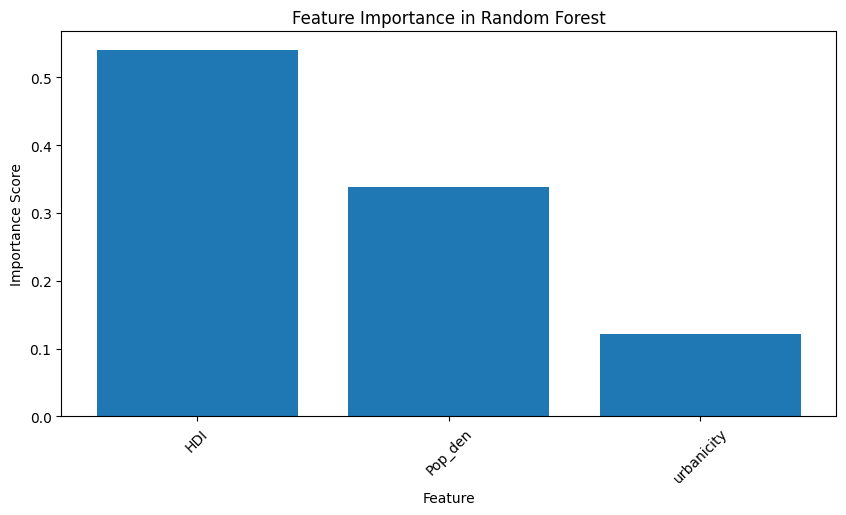

In [43]:
# Get feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [44]:
# Save the model
with open("../model weights/rf/random_forest_model.pkl", "wb") as f:
    pickle.dump(rf, f)

# Load the model
#with open("random_forest_model.pkl", "rb") as f:
#    rf_loaded = pickle.load(f)